
# Visualizing AFQ derivatives

Visualizing the results of a pyAFQ analysis is useful because it allows us to
inspect the results of the analysis and to communicate the results to others.
The pyAFQ pipeline produces a number of different kinds of outputs, including
visualizations that can be used for quality control and for quick examination
of the results of the analysis.

However, when communicating the results of pyAFQ analysis, it is often useful
to have more specific control over the visualization that is produced. In
addition, it is often useful to have visualizations that are visually appealing
and striking. In this tutorial, we will use the [fury](https://fury.gl/)
library [1]_ to visualize outputs of pyAFQ as publication-ready figures.


In [1]:
import os
import os.path as op
import nibabel as nib
import numpy as np

from dipy.io.streamline import load_trk
from dipy.tracking.streamline import transform_streamlines

from fury import actor, window
from fury.colormap import create_colormap

import AFQ.data.fetch as afd
from AFQ.viz.utils import PanelFigure

## Get some data from HBN POD2
The Healthy Brain Network Preprocessed Open Diffusion Derivatives (HBN POD2)
is a collection of resources based on the Healthy Brain Network dataset
[2, 3]_. HBN POD2 includes data derivatives - including pyAFQ derivatives -
from more than 2,000 subjects. The data and the derivatives can be browsed at
https://fcp-indi.s3.amazonaws.com/index.html#data/Projects/HBN/BIDS_curated/

Here, we will visualize the results from one subject, together with their
anatomy and using several variations. We start by downloading their
pyAFQ-processed data using fetcher functions that download both the
preprocessed data, as well as the pyAFQ-processed data (Note that this
will take up about 1.75 GB of disk space):



In [2]:
afd.fetch_hbn_preproc(["NDARAA948VFH"])
study_path = afd.fetch_hbn_afq(["NDARAA948VFH"])[1]

deriv_path = op.join(
    study_path, "derivatives")

afq_path = op.join(
    deriv_path,
    'afq',
    'sub-NDARAA948VFH',
    'ses-HBNsiteRU')

bundle_path = op.join(afq_path,
                      'bundles')

## Read data into memory
The bundle coordinates from pyAFQ are always saved in the reference frame of
the diffusion data from which they are generated, so we need an image file
with the dMRI coordinates as a reference for loading the data (we could also
use `"same"` here).



In [3]:
fa_img = nib.load(op.join(afq_path,
                          'sub-NDARAA948VFH_ses-HBNsiteRU_acq-64dir_space-T1w_desc-preproc_dwi_model-DKI_FA.nii.gz'))
fa = fa_img.get_fdata()
sft_arc = load_trk(op.join(bundle_path,
                           'sub-NDARAA948VFH_ses-HBNsiteRU_acq-64dir_space-T1w_desc-preproc_dwi_space-RASMM_model-CSD_desc-prob-afq-ARC_L_tractography.trk'), fa_img)
sft_cst = load_trk(op.join(bundle_path,
                           'sub-NDARAA948VFH_ses-HBNsiteRU_acq-64dir_space-T1w_desc-preproc_dwi_space-RASMM_model-CSD_desc-prob-afq-CST_L_tractography.trk'), fa_img)

## Transform into the T1w reference frame
Our first goal is to visualize the bundles with a background of the
T1-weighted image, which provides anatomical context. We read in this data and
transform the bundle coordinates, first into the RASMM common coordinate frame
and then subsequently into the coordinate frame of the T1-weighted data (if
you find this confusing, you can brush up on this topic in the
[nibabel documentation](https://nipy.org/nibabel/coordinate_systems.html)).



In [4]:
t1w_img = nib.load(op.join(deriv_path,
                           'qsiprep/sub-NDARAA948VFH/anat/sub-NDARAA948VFH_desc-preproc_T1w.nii.gz'))
t1w = t1w_img.get_fdata()
sft_arc.to_rasmm()
sft_cst.to_rasmm()
arc_t1w = transform_streamlines(sft_arc.streamlines,
                                np.linalg.inv(t1w_img.affine))
cst_t1w = transform_streamlines(sft_cst.streamlines,
                                np.linalg.inv(t1w_img.affine))

<div class="alert alert-info"><h4>Note</h4><p>A virtual frame buffer is needed if you are running this example on
  a machine that is not connected to a display ("headless"). If this is
  the case, you can either set an environment variable called `XVFB` to `1`
  or you can deindent the following code (and comment out the `if` statement)
  to initialize the virtual frame buffer.</p></div>



In [9]:
import xvfbwrapper
from xvfbwrapper import Xvfb

vdisplay = Xvfb()
vdisplay.start()

## Visualizing bundles with principal direction coloring
The first visualization we will create will have the streamlines colored
according to their direction. The color of each streamline will be RGB encoded
according to the RAS of the average orientation of its segments. This is the
default behavior in fury.

Fury uses "actors" to render different kind of graphics. For the bundles, we
will use the `line` actor. These objects are wrappers around the [vtkActor
class](https://vtk.org/doc/nightly/html/classvtkActor.html), so methods of
that class (like `GetProperty()`) are available to use. We like to set the
aesthetics of the streamlines, so that they are rendered as tubes and with
slightly thicker line-width than the default. We create a function that sets
these properties of the line actor via the `GetProperty` method. We will
reuse this function later on, also setting the key-word arguments to the call
to `actor.line`, but for now we use the default setting, which colors each
streamline based on the RAS orientation, and we set the line width to 8.



In [10]:
def lines_as_tubes(sl, line_width, **kwargs):
    line_actor = actor.line(sl, **kwargs)
    line_actor.GetProperty().SetRenderLinesAsTubes(1)
    line_actor.GetProperty().SetLineWidth(line_width)
    return line_actor


arc_actor = lines_as_tubes(arc_t1w, 8)
cst_actor = lines_as_tubes(cst_t1w, 8)

## Slicer actors
The anatomical image is rendered using `slicer` actors. These are actors that
visualize one slice of a three dimensional volume. Again, we create a helper
function that will slice a volume along the x, y, and z dimensions. This
function returns a list of the slicers we want to include in our
visualization. This can be one, two, or three slicers, depending on how many
of {x,y,z} are set. If you are curious to understand what is going on in this
function, take a look at the documentation for the
:met:`actor.slicer.display_extent` method (hint: for every dimension you
select on, you want the full extent of the image on the two *other* two
dimensions). We call the function on the T1-weighted data, selecting the # x
slice that is half-way through the x dimension of the image (`shape[0]`) and
the z slice that is a third of a way through that x dimension of the image
(`shape[-1]`).



In [11]:
def slice_volume(data, x=None, y=None, z=None):
    slicer_actors = []
    slicer_actor_z = actor.slicer(data)
    if z is not None:
        slicer_actor_z.display_extent(
            0, data.shape[0] - 1,
            0, data.shape[1] - 1,
            z, z)
        slicer_actors.append(slicer_actor_z)
    if y is not None:
        slicer_actor_y = slicer_actor_z.copy()
        slicer_actor_y.display_extent(
            0, data.shape[0] - 1,
            y, y,
            0, data.shape[2] - 1)
        slicer_actors.append(slicer_actor_y)
    if x is not None:
        slicer_actor_x = slicer_actor_z.copy()
        slicer_actor_x.display_extent(
            x, x,
            0, data.shape[1] - 1,
            0, data.shape[2] - 1)
        slicer_actors.append(slicer_actor_x)

    return slicer_actors


slicers = slice_volume(t1w, x=t1w.shape[0] // 2, z=t1w.shape[-1] // 3)

## Making a `scene`
The next kind of fury object we will be working with is a `window.Scene`
object. This is the (3D!) canvas on which we are drawing the actors. We
initialize this object and call the `scene.add` method to add the actors.



In [12]:
scene = window.Scene()

scene.add(arc_actor)
scene.add(cst_actor)
for slicer in slicers:
    scene.add(slicer)

## Showing the visualization
If you are working in an interactive session, you can call::

    window.show(scene, size=(1200, 1200), reset_camera=False)

to see what the visualization looks like. This would pop up a window that will
show you the visualization as it is now. You can interact with this
visualization using your mouse to rotate the image in 3D, and mouse+ctrl or
mouse+shift to pan and rotate it in plane, respectively. Use the scroll up and
scroll down in your mouse to zoom in and out. Once you have found a view of
the data that you like, you can close the window (as long as its open, it is
blocking execution of any further commands in the Python interpreter!) and
then you can query your scene for the "camera settings" by calling::

    scene.camera_info()

This will print out to the screen something like this::

    # Active Camera
       Position (238.04, 174.48, 143.04)
       Focal Point (96.32, 110.34, 84.48)
       View Up (-0.33, -0.12, 0.94)

We can use the information we have gleaned to set the camera on subsequent
visualization that use this scene object.



In [13]:
scene.set_camera(position=(238.04, 174.48, 143.04),
                 focal_point=(96.32, 110.34, 84.48),
                 view_up=(-0.33, -0.12, 0.94))

## Record the visualization
If you are not working in an interactive session, or you have already figured
out the camera settings that work for you, you can go ahead and record the
image into a png file. We use a pretty high resolution here (2400 by 2400) so
that we get a nice crisp image. That also means the file is pretty large.



In [14]:
out_folder = op.join(afd.afq_home, "VizExample")
os.makedirs(out_folder, exist_ok=True)
window.record(
    scene,
    out_path=op.join(out_folder, 'arc_cst1.png'),
    size=(2400, 2400))

/opt/conda/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: UserWarning: We'll no longer accept the way you call the record function in future versions of FURY.

Here's how to call the Function record: record(scene='value', cam_pos='value', cam_focal='value', cam_view='value', out_path='value', path_numbering='value', n_frames='value', az_ang='value', magnification='value', size='value', reset_camera='value', screen_clip='value', stereo='value', verbose='value')

  exec(code_obj, self.user_global_ns, self.user_ns)


## Setting bundle colors
The default behavior produces a nice image! But we often want to be able to
differentiate streamlines based on the bundle to which they belong. For this,
we will set the color of each streamline, based on the bundle. We often use
the Tableau20 color palette to set the colors for the different bundles. The
`actor.line` initializer takes `colors` as a keyword argument and one of the
options to pass here is an RGB triplet, which will determine the color of all
of the streamlines in that actor. We can get the Tableau20 RGB triplets from
Matplotlib's colormap module. We initialize our bundle actors again and clear
the scene before adding these new actors and adding back the slice actors. We
then call `record` to create this new figure.



In [15]:
from matplotlib.cm import tab20
color_arc = tab20.colors[18]
color_cst = tab20.colors[2]

arc_actor = lines_as_tubes(arc_t1w, 8, colors=color_arc)
cst_actor = lines_as_tubes(cst_t1w, 8, colors=color_cst)

scene.clear()

scene.add(arc_actor)
scene.add(cst_actor)
for slicer in slicers:
    scene.add(slicer)

window.record(
    scene,
    out_path=op.join(out_folder, 'arc_cst2.png'),
    size=(2400, 2400))

## Adding core bundles with tract profiles
Next, we'd like to add a representation of the core of each bundle and plot
the profile of some property along the length of the bundle. Another option
for setting streamline colors is for each point along a streamline to have a a
different color. Here, we will do this with only one streamline, which
represents the core of the fiber -- it's median trajectory, and with a profile
of the FA. This requires a few distinct steps. The first is adding another
actor for each of the core fibers. We determine the core bundle as the median
of the coordinates of the streamlines after each streamline is resampled to
100 equi-distant points. In the next step, we extract the FA profiles for each
of the bundles, using the `afq_profile` function. Before we do this, we make
sure that the streamlines are back in the voxel coordinate frame of the FA
volume. The core bundle and FA profile are put together into a new line actor,
which we initialize as a thick tube (line width of 40) and with a call to
create a colormap from the FA profiles (we can choose which color-map to use
here. In this case, we chose `'viridis'`). Note that because we are passing
only one streamline into the line actor, we have to pass it inside of square
brackets (`[]`). This is because the `actor.line` initializer expects a
sequence of streamlines as input. Before plotting things again, we initialize
our bundle line actors again. This time, we set the opacity of the lines to
0.1, so that they do not occlude the view of the core bundle visualizations.

<div class="alert alert-info"><h4>Note</h4><p>In this case, the profile is FA, but you can use any sequence of 100
  numbers in place of the FA profiles: group differences, p-values, etc.</p></div>




In [16]:
from dipy.tracking.streamline import set_number_of_points
core_arc = np.median(np.asarray(set_number_of_points(arc_t1w, 100)), axis=0)
core_cst = np.median(np.asarray(set_number_of_points(cst_t1w, 100)), axis=0)


from dipy.stats.analysis import afq_profile
sft_arc.to_vox()
sft_cst.to_vox()
arc_profile = afq_profile(fa, sft_arc.streamlines, affine=np.eye(4))
cst_profile = afq_profile(fa, sft_cst.streamlines, affine=np.eye(4))

core_arc_actor = lines_as_tubes(
    [core_arc],
    40,
    colors=create_colormap(arc_profile, 'viridis')
)

core_cst_actor = lines_as_tubes(
    [core_cst],
    40,
    colors=create_colormap(cst_profile, 'viridis')
)

scene.clear()

arc_actor = lines_as_tubes(arc_t1w, 8, colors=color_arc, opacity=0.1)
cst_actor = lines_as_tubes(cst_t1w, 8, colors=color_cst, opacity=0.1)

scene.add(arc_actor)
scene.add(cst_actor)
for slicer in slicers:
    scene.add(slicer)
scene.add(core_arc_actor)
scene.add(core_cst_actor)

window.record(
    scene,
    out_path=op.join(out_folder, 'arc_cst3.png'),
    size=(2400, 2400))

/opt/conda/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: UserWarning: We'll no longer accept the way you call the create_colormap function in future versions of FURY.

Here's how to call the Function create_colormap: create_colormap(v_value, name='value', auto='value')

  exec(code_obj, self.user_global_ns, self.user_ns)


## Adding ROIs
Another element that we can add into the visualization are volume renderings
of regions of interest. For example, the waypoint ROIs that were used to
define the bundles. Here, we will add the waypoints that were used to define
the arcuate fasciculus in this subject. We start by reading this data in.
Because it is represented in the space of the diffusion data, it too needs to
be resampled into the T1-weighted space, before being visualized. After
resampling, we might have some values between 0 and 1 because of the
interpolation from the low resolution of the diffusion into the high
resolution of the T1-weighted. We will include in the volume rendering any
values larger than 0. The main change from the previous visualizations is the
adition of a `contour_from_roi` actor for each of the ROIs. We select another
color from the Tableau 20 palette to represent this, and use an opacity of
0.5.

<div class="alert alert-info"><h4>Note</h4><p>In this case, the surface rendered is of the waypoint ROIs, but very
  similar code can be used to render other surfaces, provided a volume that
  contains that surface. For example, the gray-white matter boundary could
  be visualized provided an array with a binary representation of the volume #   enclosed in this boundary</p></div>



In [17]:
from dipy.align import resample

waypoint1 = nib.load(
    op.join(
        afq_path,
        "ROIs", "sub-NDARAA948VFH_ses-HBNsiteRU_acq-64dir_space-T1w_desc-preproc_dwi_desc-ROI-ARC_L-1-include.nii.gz"))

waypoint2 = nib.load(
    op.join(
        afq_path,
        "ROIs", "sub-NDARAA948VFH_ses-HBNsiteRU_acq-64dir_space-T1w_desc-preproc_dwi_desc-ROI-ARC_L-2-include.nii.gz"))

waypoint1_xform = resample(waypoint1, t1w_img)
waypoint2_xform = resample(waypoint2, t1w_img)
waypoint1_data = waypoint1_xform.get_fdata() > 0
waypoint2_data = waypoint2_xform.get_fdata() > 0

scene.clear()

arc_actor = lines_as_tubes(arc_t1w, 8, colors=color_arc)
cst_actor = lines_as_tubes(cst_t1w, 8, colors=color_cst)

scene.add(arc_actor)
scene.add(cst_actor)
for slicer in slicers:
    scene.add(slicer)

surface_color = tab20.colors[0]

waypoint1_actor = actor.contour_from_roi(waypoint1_data,
                                         color=surface_color,
                                         opacity=0.5)

waypoint2_actor = actor.contour_from_roi(waypoint2_data,
                                         color=surface_color,
                                         opacity=0.5)


scene.add(waypoint1_actor)
scene.add(waypoint2_actor)


window.record(
    scene,
    out_path=op.join(out_folder, 'arc_cst4.png'),
    size=(2400, 2400))

## Making a Figure out of many fury panels
We can also make a figure that contains multiple panels, each of which
contains a different visualization. This is useful for communicating the
results of an analysis. Here, we will make a figure with four panels, using
some of the visualizations we have already created. We will use some
convenient methods from pyAFQ.



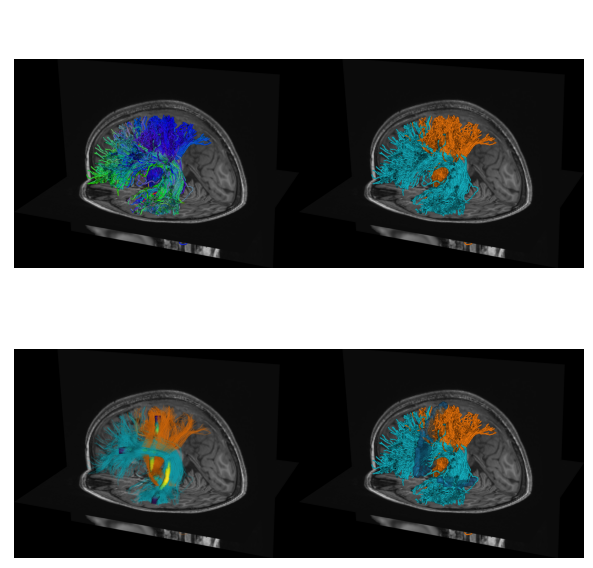

In [18]:
pf = PanelFigure(3, 2, 6, 9)
pf.add_img(op.join(out_folder, 'arc_cst1.png'), 0, 0)
pf.add_img(op.join(out_folder, 'arc_cst2.png'), 1, 0)
pf.add_img(op.join(out_folder, 'arc_cst3.png'), 0, 1)
pf.add_img(op.join(out_folder, 'arc_cst4.png'), 1, 1)
pf.format_and_save_figure(f"arc_cst_fig.png")

<div class="alert alert-info"><h4>Note</h4><p>If a virtual buffer was started before, it's a good idea to stop it.</p></div>



In [ ]:
if os.environ.get("XVFB", False):
    print("Stopping XVFB")
    vdisplay.stop()

## References
.. [1] Garyfallidis et al., (2021). FURY: advanced scientific visualization.
   Journal of Open Source Software, 6(64), 3384,
   https://doi.org/10.21105/joss.03384

.. [2] Alexander LM, Escalera J, Ai L, et al. An open resource for
    transdiagnostic research in pediatric mental health and learning
    disorders. Sci Data. 2017;4:170181.

.. [3] Richie-Halford A, Cieslak M, Ai L, et al. An analysis-ready and
    quality controlled resource for pediatric brain white-matter research.
    Scientific Data. 2022;9(1):1-27.

